In [10]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from toolbox import *
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
init_y, init_x, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
init_y = (init_y + 1.0) * 0.5

In [3]:
def cropped_of_rows_with_999_value(x, y):
    for i in range(x.shape[1]):
        idxes = (x[:, i] != -999)
        x = x[idxes]
        y = y[idxes]
    return x, y

def columns_with_999_value(x):
    indexes = []
    for i in range(x.shape[1]):
        if np.any(x[:, i] == -999.0):
            indexes.append(i)
    return indexes

def cropped_of_columns(x, columns_indexes):
    return np.delete(x, columns_indexes, axis = 1)

def augment(x, n):
    return x if n == 1 else np.append(augment(x, n - 1), x ** n, axis = 1)

## Transform `x` and `y` as you want here using the functions above

In [27]:
# IF YOU DO TRANSFORMATIONS WHICH AFFECT THE SHAPE OF X, DON'T FORGET TO
# MAKE THE SAME TRANSFORMATIONS ON X_TEST AT THE END

rem_indexes = columns_with_999_value(init_x) # []
rem_indexes.remove(0)

# Comment one of the two (first one deletes columns, second one deletes rows)
x, y = cropped_of_columns(init_x, rem_indexes), init_y
#x, y = cropped_of_rows_with_999_value(init_x, init_y)

x = augment(x, 6)

tx, mean, var = standardize(x)

print(tx.shape)

(250000, 121)


## Visualizations

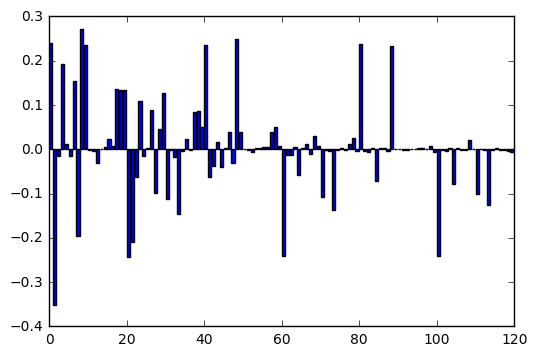

In [28]:
def plot_feature_to_output_correlations(tx, y):
    feature_count = tx.shape[1]

    corrs = np.zeros(feature_count)
    for i in range(feature_count):
        x = tx[:, i]
        corrs[i] = np.corrcoef(x, y)[0][1]

    fig, ax = plt.subplots()
    width = 0.5

    ax.bar(np.arange(feature_count), corrs)

plot_feature_to_output_correlations(x, y)

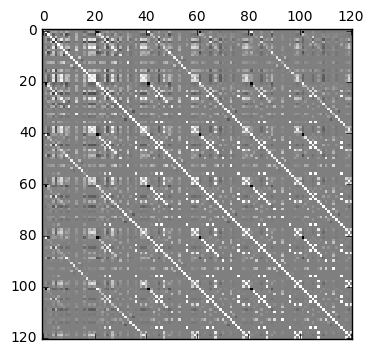

In [29]:
G = tx.T @ tx
plt.matshow(G, cmap=plt.cm.gray)

## Learning phase

In [32]:
loss, w = logistic_regression(y, tx, np.zeros(tx.shape[1]), 0.05, 10000)

## Test predictions against train set output

In [33]:
y_pred_train = expit(tx @ w)

y_pred_train[y_pred_train <  0.5] = 0
y_pred_train[y_pred_train >= 0.5] = 1

np.count_nonzero(y_pred_train == y) / len(y)

0.776168

## Generate predictions and save ouput in csv format for submission:

In [38]:
DATA_TEST_PATH = 'test.csv' # TODO: download train data and supply path here 
_, init_x_test, ids_test = load_csv_data(DATA_TEST_PATH)

x_test = cropped_of_columns(init_x_test, rem_indexes)
#x_test = init_x_test
x_test = augment(x_test, 6)

tx_test, _, _ = standardize(x_test, mean, var)

print(tx_test.shape)

(568238, 121)


In [39]:
OUTPUT_PATH = 'out.csv' # TODO: fill in desired name of output file for submission
y_pred = expit(tx_test @ w)

y_pred[np.where(y_pred <  0.5)] = -1
y_pred[np.where(y_pred >= 0.5)] = 1

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)